In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from requests import head

import tensorflow as tf
import tensorflow_hub as hub

In [11]:
df = pd.read_csv('wine-reviews.csv' , usecols= ['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


<function matplotlib.pyplot.show(close=None, block=None)>

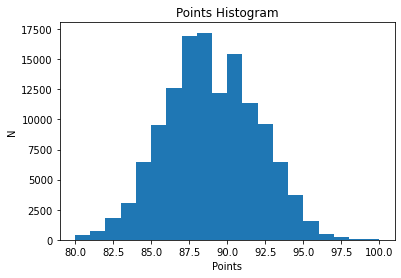

In [12]:
plt.hist(df.points, bins = 20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show

In [13]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "points", "label"]]

In [14]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [15]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [16]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

Embedding + Model

Tranform text into 0's and 1's

In [17]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [18]:
hub_layer(list(train_data)[0] [0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.26665422, -0.46004838, -0.16539912, ...,  0.10266569,
        -0.02534796, -0.07109562],
       [ 0.11634789,  0.15760927,  0.14696649, ..., -0.15370964,
        -0.12554954,  0.13824193],
       [ 0.25676176, -0.17266719, -0.09802071, ..., -0.01340493,
        -0.22862524,  0.06983932],
       ...,
       [ 0.2961369 , -0.08001649,  0.35447484, ...,  0.03551536,
        -0.20157681,  0.05810295],
       [ 0.45625845,  0.04204088, -0.03038556, ..., -0.20671917,
        -0.34914622, -0.02777541],
       [ 0.21615869, -0.0275948 ,  0.04010678, ..., -0.296058  ,
        -0.12402051,  0.04310131]], dtype=float32)>

In [19]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [21]:
model.evaluate(train_data)

102/102 [==============================] - 2s 9ms/step - loss: 0.7512 - accuracy: 0.3772


[0.7512136101722717, 0.3771735727787018]

In [22]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 10ms/step - loss: 0.7508 - accuracy: 0.3760


[0.7507715821266174, 0.37600985169410706]

In [23]:
history = model.fit(train_data, epochs = 10, validation_data = valid_data)

Epoch 1/10
102/102 [==============================] - 65s 629ms/step - loss: 0.5738 - accuracy: 0.6820 - val_loss: 0.4256 - val_accuracy: 0.8033
Epoch 2/10
102/102 [==============================] - 63s 617ms/step - loss: 0.3769 - accuracy: 0.8283 - val_loss: 0.3771 - val_accuracy: 0.8253
Epoch 3/10
102/102 [==============================] - 63s 615ms/step - loss: 0.3325 - accuracy: 0.8523 - val_loss: 0.3679 - val_accuracy: 0.8324
Epoch 4/10
102/102 [==============================] - 63s 619ms/step - loss: 0.3076 - accuracy: 0.8651 - val_loss: 0.3672 - val_accuracy: 0.8332
Epoch 5/10
102/102 [==============================] - 64s 631ms/step - loss: 0.2887 - accuracy: 0.8759 - val_loss: 0.3708 - val_accuracy: 0.8327
Epoch 6/10
102/102 [==============================] - 63s 616ms/step - loss: 0.2730 - accuracy: 0.8838 - val_loss: 0.3776 - val_accuracy: 0.8334
Epoch 7/10
102/102 [==============================] - 63s 614ms/step - loss: 0.2579 - accuracy: 0.8915 - val_loss: 0.3820 - val_ac

In [24]:
model.evaluate(test_data)

13/13 [==============================] - 1s 64ms/step - loss: 0.4164 - accuracy: 0.8330


[0.4164310693740845, 0.8329743146896362]

LSTM

In [26]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))


In [27]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [31]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 1s 104ms/step - loss: 0.6933 - accuracy: 0.4913


[0.6932671070098877, 0.49126720428466797]

In [ ]:
history = model.fit(train_data, epochs = 5, validation_data = valid_data)

In [ ]:
model.evaluate(test_data)